In [4]:
# import necessary libraries
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import xlrd
#from scipy.interpolate import make_interp_spline, BSpline

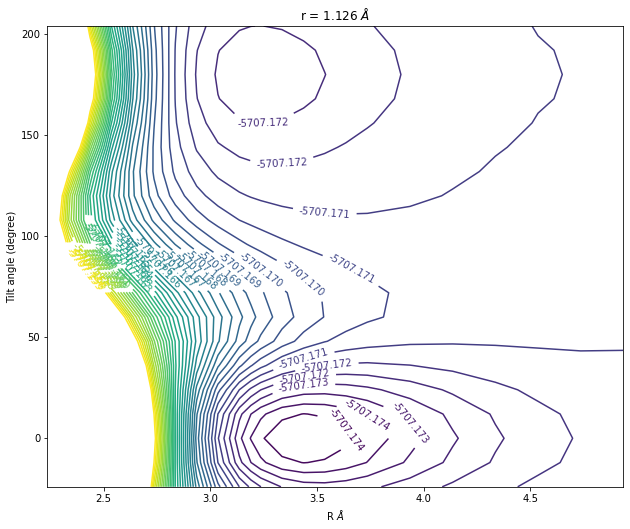

In [5]:
# Plot the PES at r = 1.126

workbook = xlrd.open_workbook('PES_1_3d_x0.xlsx', on_demand=True)

# r indices:
# [0.876, 0.926, 1.026, 1.126, 1.226, 1.326, 1.426, 1.526, 1.59, 1.626, 1.726, 1.826] \AA
# corresponding to [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
r_idx = 3

# The number of points for tilt angle and R
# Use this to select a PES range
size_tilt = 21
size_R = 25

# Read the data
PES_r = workbook.sheet_by_index(r_idx)
tilt = PES_r.col_values(0, 1, size_tilt)
R = PES_r.row_values(0, 1, size_R)

data=[]

for i in range(1, size_R):
    data.append(PES_r.col_values(i, 1, size_R))
    
# Create grids
X = np.array(tilt)
Y = np.array(R)
Z = np.array(data)

X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')    
#ax.plot_surface(X, Y, Z)
#plt.show()

# Plot the figure
# Set zero value and equator line spacing
Zero_shift = -5707.1748259197 # Zero shift, in Eh
spacing = 0.0005 # distance between lines, in Eh
maxline = 40 # maxium number of lines
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8

ax = fig.add_axes([left, bottom, width, height])
levels = [Zero_shift + i*spacing for i in range(maxline)]
cp = ax.contour(Y, X, Z, levels)
ax.clabel(cp, inline=True, 
          fontsize=10)
ax.set_title('r = 1.126 $\AA$')
ax.set_xlabel('R $\AA$')
ax.set_ylabel('Tilt angle (degree)')
plt.show()

In [6]:
# Starting regression analysis
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

In [7]:
# Read data and convert into pandas dataframe
rlist = [0.876, 0.926, 1.026, 1.126, 1.226, 1.326, 1.426, 1.526, 1.59, 1.626, 1.726, 1.826]
Rlist = [2.236, 2.336, 2.436, 2.536, 2.636, 2.736, 2.836, 2.936, 3.036, 3.136, 3.19, 3.236, 3.336, 3.436, 3.44, 3.536, 3.636, 3.736, 3.936, 4.136, 4.336, 4.536, 4.736, 4.936]
theta_list = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180]
# theta should be converted to cos(theta)

data = {'r': [],
'R': [],
'cos_theta': [],
'Energy': []}

for ridx, ri in enumerate(rlist):
    for Ridx, Ri in enumerate(Rlist):
        for tidx, ti in enumerate(theta_list):
            data['r'].append(ri)
            data['R'].append(Ri)
            #data['theta'].append(ti)
            data['cos_theta'].append(np.cos(np.pi * ti/180.0))
            PES_r = workbook.sheet_by_index(ridx)
            E = PES_r.cell(tidx+3, Ridx+1).value
            data['Energy'].append(E)
            # write this label into dataframe

df = pd.DataFrame(data,columns=['r',  'R', 'cos_theta',  'Energy'])
#df = pd.DataFrame(data,columns=['r',  'R', 'theta',  'Energy'])
#df[df['R'] == 4.936].head(20)
df.head()

,r,R,cos_theta,Energy
0,0.876,2.236,1.000000,-5706.803124
1,0.876,2.236,0.978148,-5706.803137
2,0.876,2.236,0.913545,-5706.815137
3,0.876,2.236,0.809017,-5706.829497
4,0.876,2.236,0.669131,-5706.842390


In [8]:
df.shape

(4608, 4)

0.17654055467632268
0.14238987117680435


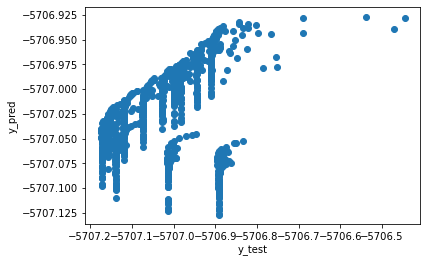

In [9]:
# Simple 3 variable linear regression

X = df[['r', 'R', 'cos_theta']]
y = df['Energy']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize r, R, theta, and Energy (train)
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

# Build linear model
lr = LinearRegression()
lr.fit(X_train_s, y_train)

# Compute in-sample R2
y_tilde = lr.predict(X_train_s)
rt = r2_score(y_train, y_tilde)
print(rt)

# Transform X_test and predict E_test
X_test_s = s.transform(X_test)
y_pred = lr.predict(X_test_s)

# Evaluate R^2
rs = r2_score(y_test, y_pred)
print(rs)

# Plot regression line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.scatter(y_test, y_pred)

0.98057437686591
0.9812657928346531


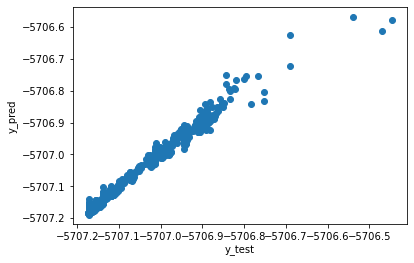

In [10]:
# 3 variable linear regression with PolynomialFeatures

X = df[['r', 'R', 'cos_theta']]
y = df['Energy']

# Polinomial features
pf = PolynomialFeatures(4)
X_pf = pf.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=42)

# Standardize r, R, theta, and Energy (train)
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

# Build linear model
lr_pf = LinearRegression()
lr_pf.fit(X_train_s, y_train)

# Compute in-sample R2
y_tilde = lr_pf.predict(X_train_s)
rt = r2_score(y_train, y_tilde)
print(rt)

# Transform X_test and predict E_test
X_test_s = s.transform(X_test)
y_pred = lr_pf.predict(X_test_s)

# Evaluate R^2
rs = r2_score(y_test, y_pred)
print(rs)

# Plot regression line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.scatter(y_test, y_pred)

0.8429666291415301
0.83811082360179


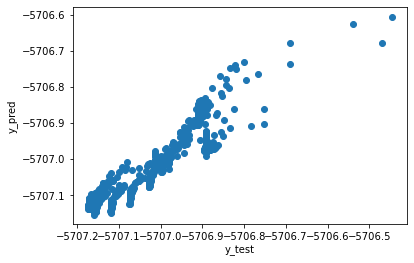

In [11]:
# 3 variable linear regression with L2 regularization

# Polinomial features
pf = PolynomialFeatures(4)
X_pf = pf.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=42)

# Standardize r, R, theta, and Energy (train)
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

# Build Ridge regression model
clf = Ridge(alpha=1.0)
clf.fit(X_train_s, y_train)

# Compute in-sample R2
y_tilde = clf.predict(X_train_s)
rt = r2_score(y_train, y_tilde)
print(rt)

# Transform X_test and predict E_test
X_test_s = s.transform(X_test)
y_pred = clf.predict(X_test_s)

# Evaluate R^2
rs = r2_score(y_test, y_pred)
print(rs)

# Plot regression line
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.scatter(y_test, y_pred)

In [13]:
# Try to use selected model to predict CO energy at any place

model = clf

to_pred = {'r': [1.14],
'R': [3.0],
'cos_theta': [np.cos(np.pi * 25 / 180)]}

data_inp = pd.DataFrame(to_pred,columns=['r',  'R', 'cos_theta'])

data_inp_pf = pf.fit_transform(data_inp)
X_inp_s = s.transform(data_inp_pf)
res = model.predict(X_inp_s)
print(res)

[-5707.11156686]


In [15]:
# Build the function pipeline
def CO_energy(x, *args):
    #print(args)
    model = args[0]
    to_pred = {'r': [x[0]],
    'R': [x[1]],
    'cos_theta': [np.cos(np.pi * x[2] / 180)]}
    data_inp = pd.DataFrame(to_pred,columns=['r',  'R', 'cos_theta'])
    for t in args[1:]:
        data_inp = t.transform(data_inp)
    return model.predict(data_inp)

In [16]:
print(CO_energy([1.14, 3.0, 0], clf, pf, s))

[-5707.10589744]


In [17]:
# Optimize the energy function to find the minimal geometries using scipy
from scipy.optimize import minimize
x0 = [1.14, 3.0, 0]
res = minimize(CO_energy, x0, args=(lr_pf, pf, s), method='BFGS', jac='2-point', options={'maxiter': 100, 'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: -5707.185014
         Iterations: 9
         Function evaluations: 48
         Gradient evaluations: 12
      fun: -5707.185013553603
 hess_inv: array([[ 0.17431727, -0.1046366 ,  0.        ],
       [-0.1046366 , 16.79693466,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([1.13904307, 3.50084348, 0.        ])


In [18]:
print(CO_energy([1.2, 20.0, 30], lr_pf, pf, s))

[-4657.11229737]
